## Import required libraries

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import re, nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/supsaha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load the dataset

In [121]:
df = pd.read_csv('spam.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [122]:
df.shape

(5572, 2)

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [124]:
df.describe()

,Category,Message
count,5572,5572
unique,2,5157
top,ham,"Sorry, I'll call later"
freq,4825,30


## Data Preprocessing and cleaning

In [125]:
## Check for null
df.isnull().sum()

Category    0
Message     0
dtype: int64

In [126]:
## Check for duplicates
df.duplicated().sum()

415

In [127]:
df.drop_duplicates(inplace=True)
df.shape

(5157, 2)

In [128]:
## Output distribution
df['Category'].value_counts()

Category
ham     4516
spam     641
Name: count, dtype: int64

In [129]:
round(df['Category'].value_counts(normalize=True) * 100, 2)

Category
ham     87.57
spam    12.43
Name: proportion, dtype: float64

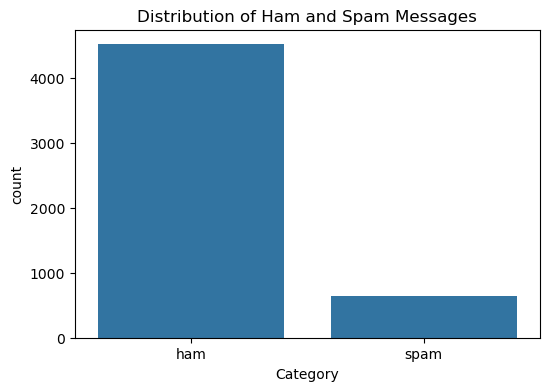

In [130]:
plt.figure(figsize=(6,4))
sns.countplot(x='Category',data=df)
plt.title('Distribution of Ham and Spam Messages')
plt.show()

13% spam emails, 87% ham emails: This indicates class imbalance¶. However, our major focus will be on the evaluating model using precsion/Recall rather than accuracy.

In [131]:
## Label encoding
label_encode = {'ham':0, 'spam': 1}
df['label']= df['Category'].map(label_encode)

In [132]:
df.head()

,Category,Message,label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [133]:
df.drop('Category', axis=1, inplace=True)
df.head()

,Message,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


### Import NLP libraries

In [134]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [135]:
# Create a function to clean messages

def clean_message(text):
    text = text.lower()   #Convert to lowercase
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  #Remove URLs
    text = re.sub(r'<.*?>', '', text)   #Remove HTML tags
    text = re.sub(r'\S+@\S+', '', text)   #Remove email addresses
    text = re.sub(r'[^a-zA-Z\s]', '', text) #Remove numbers and special characters
    text = ' '.join(text.split())  #Remove extra whitespace 
    return text

In [136]:
df['Message'] = df['Message'].apply(clean_message)
df.head()

,Message,label
0,go until jurong point crazy available only in ...,0
1,ok lar joking wif u oni,0
2,free entry in a wkly comp to win fa cup final ...,1
3,u dun say so early hor u c already then say,0
4,nah i dont think he goes to usf he lives aroun...,0


In [137]:
nltk.download('punkt')
nltk.download('stopwords')
ps = PorterStemmer()

[nltk_data] Downloading package punkt to /Users/supsaha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/supsaha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [138]:
# Remove Stopwords and apply stemming

def transform_text(text):
    text = nltk.word_tokenize(text)
    text = [word for word in text if word.isalnum()]  # alphanumeric
    text = [word for word in text if word not in stopwords.words('english')]  # remove stopwords
    text = [ps.stem(word) for word in text]  # stemming
    return " ".join(text)

In [139]:
df['Message'] = df['Message'].apply(transform_text)
df.head()

,Message,label
0,go jurong point crazi avail bugi n great world...,0
1,ok lar joke wif u oni,0
2,free entri wkli comp win fa cup final tkt st m...,1
3,u dun say earli hor u c alreadi say,0
4,nah dont think goe usf live around though,0


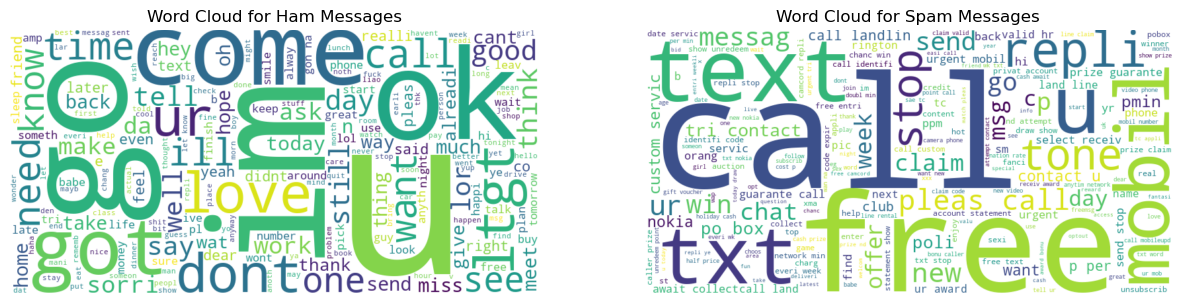

In [140]:
from wordcloud import WordCloud
ham_messages = df[df['label'] == 0]['Message']
spam_messages = df[df['label'] == 1]['Message']

ham_text = ' '.join(ham_messages)
spam_text = ' '.join(spam_messages)

ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_text)
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_text)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Ham Messages')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Spam Messages')
plt.axis('off')

plt.show()

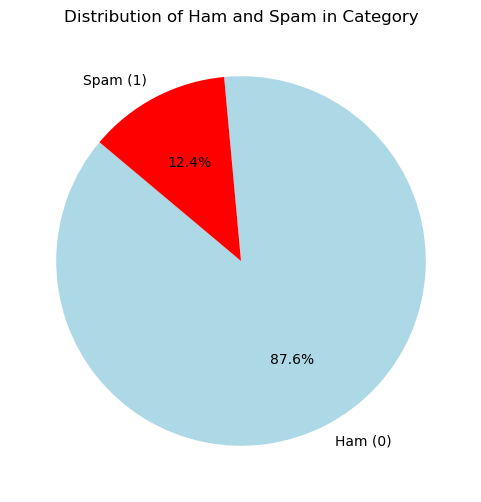

In [141]:
category_counts = df['label'].value_counts()

# Plot diagram
plt.figure(figsize=(6, 6))
plt.pie(category_counts, labels=['Ham (0)', 'Spam (1)'], autopct='%1.1f%%', startangle=140, colors=['lightblue', 'red'])
plt.title('Distribution of Ham and Spam in Category')
plt.show()

## Split the data into independent and dependent variable

In [142]:
X = df['Message']
y = df['label']
X.shape, y.shape

((5157,), (5157,))

## Spit the data into training and testing

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [144]:
## Apply TF-IDF vetorizer on the text data

tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

## Model building

In [145]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB

Accuracy Score : 0.9767441860465116
Precision Score : 0.9516129032258065
Recall Score : 0.8676470588235294
Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       896
           1       0.95      0.87      0.91       136

    accuracy                           0.98      1032
   macro avg       0.97      0.93      0.95      1032
weighted avg       0.98      0.98      0.98      1032



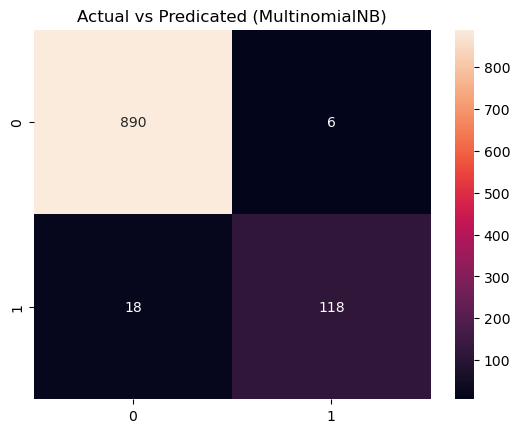

In [146]:
mnb = MultinomialNB()
mnb.fit(X_train_tfidf,y_train)
y_pred_mnb = mnb.predict(X_test_tfidf)
print("Accuracy Score :" ,accuracy_score(y_test,y_pred_mnb))
print("Precision Score :", precision_score(y_test,y_pred_mnb))
print("Recall Score :", recall_score(y_test,y_pred_mnb))
print('Classification Report: ')
print(classification_report(y_test,y_pred_mnb))
sns.heatmap(confusion_matrix(y_test,y_pred_mnb),annot=True,fmt='d')
plt.title("Actual vs Predicated (MultinomialNB)")
plt.show()

Accuracy Score : 0.7684108527131783
Precision Score : 0.35410764872521244
Recall Score : 0.9191176470588235
Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.75      0.85       896
           1       0.35      0.92      0.51       136

    accuracy                           0.77      1032
   macro avg       0.67      0.83      0.68      1032
weighted avg       0.90      0.77      0.80      1032



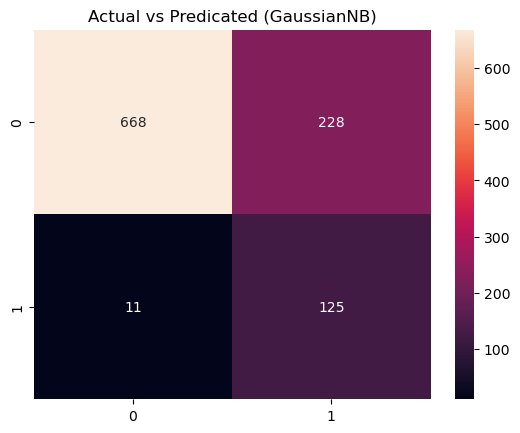

In [147]:
# Convert sparse matrix to dense array as GaussianNB does not support sparse matrix
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

gnb = GaussianNB()
gnb.fit(X_train_dense,y_train)
y_pred_gnb = gnb.predict(X_test_dense)
print("Accuracy Score :" ,accuracy_score(y_test,y_pred_gnb))
print("Precision Score :", precision_score(y_test,y_pred_gnb))
print("Recall Score :", recall_score(y_test,y_pred_gnb))
print('Classification Report: ')
print(classification_report(y_test,y_pred_gnb))
sns.heatmap(confusion_matrix(y_test,y_pred_gnb),annot=True,fmt='d')
plt.title("Actual vs Predicated (GaussianNB)")
plt.show()

Accuracy Score : 0.9825581395348837
Precision Score : 0.9682539682539683
Recall Score : 0.8970588235294118
Classification Report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       896
           1       0.97      0.90      0.93       136

    accuracy                           0.98      1032
   macro avg       0.98      0.95      0.96      1032
weighted avg       0.98      0.98      0.98      1032



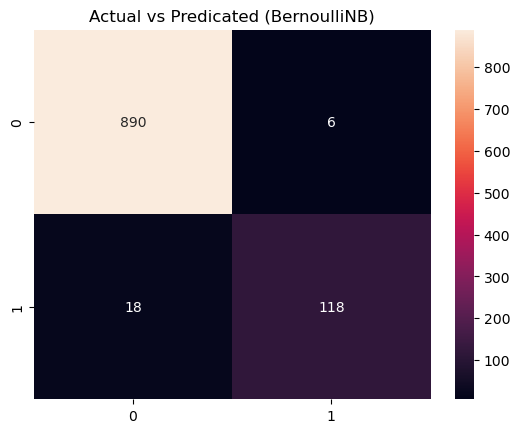

In [148]:
bnb = BernoulliNB()
bnb.fit(X_train_tfidf,y_train)
y_pred_bnb = bnb.predict(X_test_tfidf)
print("Accuracy Score :" ,accuracy_score(y_test,y_pred_bnb))
print("Precision Score :", precision_score(y_test,y_pred_bnb))
print("Recall Score :", recall_score(y_test,y_pred_bnb))
print('Classification Report: ')
print(classification_report(y_test,y_pred_bnb))
sns.heatmap(confusion_matrix(y_test,y_pred_mnb),annot=True,fmt='d')
plt.title("Actual vs Predicated (BernoulliNB)")
plt.show()

## BernoulliNB outperforms with higest accuracy of 98% along with good precision and Recall score. We will go head with model

## Saving and loading the model

In [149]:
import joblib

# Save model
joblib.dump(bnb, 'gnb_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')


# Load model
model = joblib.load('gnb_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

In [150]:
def email_prediction(text):
    
    # If input is already a list, use it directly; if it's a string, wrap it in a list
    input_email = text if isinstance(text, list) else [text]
    emails_tfidf = vectorizer.transform(input_email)
    prediction = model.predict(emails_tfidf)
    return prediction

In [151]:
emails = [
    "Hey! You won the prize $200. Please collect it before loose",
    "Meeting tomorrow at 10 AM",
    "URGENT: Claim your prize now!"
]

# Print predictions
print("\nEmail Predictions:")
print("-" * 60)
for email, pred in zip(emails, email_prediction(emails)):
    label = "SPAM" if pred == 1 else "HAM"
    print(f'Email: "{email}"')
    print(f'Prediction: {label}')
    print("-" * 60)


Email Predictions:
------------------------------------------------------------
Email: "Hey! You won the prize $200. Please collect it before loose"
Prediction: SPAM
------------------------------------------------------------
Email: "Meeting tomorrow at 10 AM"
Prediction: HAM
------------------------------------------------------------
Email: "URGENT: Claim your prize now!"
Prediction: SPAM
------------------------------------------------------------
